FileNotFoundError: [Errno 2] No such file or directory: '/Users/jackzwettler/Documents/STO_0.7Nb_3.xlsx'

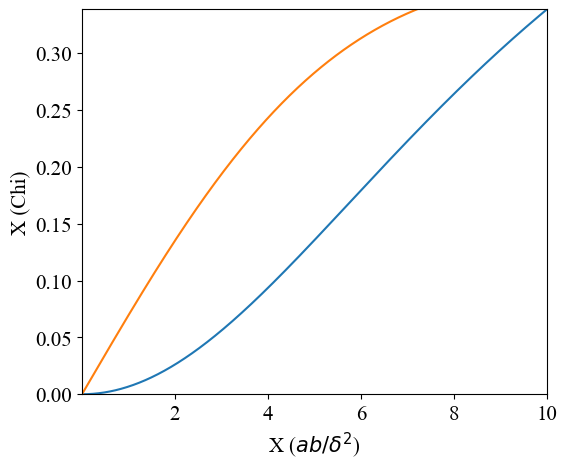

In [1]:
"""This code uses resistance data from Nb-doped STO (0.7%) to determine the appropriate parameters necessary
to convert the imaginary part of the output voltage from the contact-free probe to resistivity values."""

import matplotlib.ticker as ticker
import numpy as np
from numpy import linalg as LA
import cmath
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
from scipy.interpolate import approximate_taylor_polynomial
from scipy.interpolate import interp1d
import pandas as pd

a = 3*298/453 #x dimension in mm
b=3*305/453 #y dimension in mm

res = 49 #Minimum resolution in each direction (arbitrary)

d = np.linspace(0.001,10,1000) #d stores values of the parameter X, where 
#X=a*b/delta^2 (delta is the skin depth and sqrt(a*b) is the characteristic 
#length scale). The range of d values can be modified according to what is required,
#but a lower bound of d=0 will produce errors. For reference, the above range of X values
#at 671.111 kHz covers resistivities in the range of 10e5 to 50 uohmcm.

chis = np.zeros(1000,dtype=np.complex_) #Stores the effective magnetic 
#susceptibility for each d value of a rectangular sample (a by b units long)

for u in range(len(d)):
    delta = math.sqrt(a*b/d[u]) #skin depth
    k=(1-1j)/delta #k value
    minn = np.maximum(a,b)
    div = np.maximum(5*int(minn/delta),res) #This analysis is only useful 
    #if there are many more divisions per unit length than the inverse of 
    #the skin depth (Otherwise, valuable information is missed). This is 
    #the reason for increasing the resolution at small skin depths: div 
    #is res by default but becomes larger if the skin depth is sufficiently small.
    
    dx = a/(div+1) #stepsize: x direction
    dy = b/(div+1) #stepsize: y direction
    H0 = 1 #External field magnitude

    """This analysis solves the differential equation del^2(H)+k^2*H=0 over 
    a rectangular sample. A second order approximation for H is used, which 
    is appropriate given the presence of the Laplacian."""

    Xmat = np.zeros([div,div],dtype=np.complex_) #A matrix
    Ymat = np.zeros([div,div],dtype=np.complex_) #B matrix
    for i in range(div):
        for j in range(div):
            if (i ==j):
                Xmat[i][j]= -2/dx**2+k**2/2 #alpha_x
                Ymat[i][j]= -2/dy**2+k**2/2 #alpha_y
            elif (abs(i-j) == 1):
                Xmat[i][j]= 1/dx**2 #beta_x
                Ymat[i][j]= 1/dy**2 #beta_y


    C = np.zeros([div,div],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 
    
    for i in range(div):
        for j in range(div):
            if ((i==0) or (i == (div-1))):
                C[i][j] -= H0/dx**2 
            if ((j==0) or (j == (div-1))):
                C[i][j] -= H0/dy**2
                
    #The steps below were taken from http://aero-comlab.stanford.edu/Papers/jameson_007.pdf 
    #X is the solution to the matrix equation AX + XB = C.

    lam, U = LA.eig(Xmat) #lam stores the eigenvalues, U stores the eigenvectors
    mu, V = LA.eig(Ymat) #mu stores the eigenvales, V stores the eigenvectors

    C_hat = LA.inv(U)@C@V #Equation 16

    X_hat = np.zeros([div,div],dtype=np.complex_)
    for i in range(div):
        for j in range(div):
            X_hat[i][j] = C_hat[i][j]/(lam[i]+mu[j]) #Equation 15

    X = U@X_hat@LA.inv(V) #Equation 14
    for i in range(div):
        for j in range(div):
            if X[i][j].real > 1:
                print("Error at position ",i,", ",j) #It is unphysical for the 
                #field to be larger in magnitude within the conductor than outside of it 
                #(provided that it is not magnetic).
                
    NewX= np.zeros([div+2,div+2],dtype=np.complex_) 
    for i in range(div+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(div+2):
            if ((i ==0) or (i==(div+1)) or (j ==0) or (j==(div+1))):
                NewX[i][j] =H0 
            else:
                NewX[i][j]=X[i-1][j-1]
    summ = 0
    for i in range(div+1):
        for j in range(div+1):
            summ += (NewX[i][j]+NewX[i+1][j]+NewX[i][j+1]+NewX[i+1][j+1])*dx*dy/4 #Numerical 
            #integration of H*da
    chis[u]=summ/(H0*a*b)-1 #Solves for the effective magnetic susceptibility
    #at the given X value.
    
fig,bx = plt.subplots(1, 1, sharex = True, figsize=(6, 5))
bx.plot(d,-chis.real)
bx.plot(d,-chis.imag)
bx.set_xlabel("X ($ab/\u03B4^2$)",fontsize=15)
bx.set_ylabel("\u03A7 (Chi)",fontsize=15)
bx.tick_params(axis='x', labelsize=15)
bx.tick_params(axis='y', labelsize=15)
bx.set_xlim([min(d),max(d)])
bx.set_ylim([0,max(-chis.real)])

"""Run the top above code cell before running this one."""
import matplotlib.colors as mcolors 
f=671111 #Frequency in Hz
filepath = '/Users/jackzwettler/Documents/STO_0.7Nb_3.xlsx' #This is the file that contains
#the data from the probe.

probe_dat = pd.read_excel(filepath) #Retrieve data

res_dat= pd.read_excel('/Users/jackzwettler/Documents/STO_Sajna.xlsx') #This contains resistivity values from Sajna's measurements


"""
READ THIS!!!

    The value for the magnetic susceptibility, chi, determined above (stored in 'chis') as a function of the corresponding 
X values (stored in 'd') is related to the output voltage V by the relation V = M*chi*exp(i*T), where T is a phase
offset from the steel tube, and M is a multiplier that is (theoretically) proportional to the sample volume. T was determined by 
measuring a superconductor's output voltage (See 2021_5_1_a.xlsx). Originally, I opted to use the phase of the 
output voltage in the equation above to determine chi because M is irrelevant in that case. However, the phase 
of samples in the transparent regime is very close to -pi/2, which means that the x-component is very small relative
to the noise. It is therefore better to forgo the phase and use the imaginary part of V to determine chi. 

    This motivates the remaining section. M is unknown and the resistance data from Sajna's measurements 
do not specify sample dimensions. I therefore have to find the value of C that satisfies rho = C*R, where rho
is the resistivity and R is the measured resistance. The for loop with the line 'print("Loop time")' preceding it
performs a chi-squared fit that determines M and C to an arbitrary level of precision. Please note that

    - The precision of this method is uncertain, so STO should be measured in situ with the four-wire method 
    to verify the results.
    
    - The imaginary part dominates the signal for STO, which means that the uncertainty in T (10% of the value 
    I use) does not appreciably affect the fit values for M and C.
    
    - Note that the assumption that M is proportional to the sample volume might not be perfect: Specifically,
    M might not be linear in the height of the sample (in the direction parallel to the magnetic field).
    """
Xdat = probe_dat.to_numpy() #Contact-free
Rdat = res_dat.to_numpy() #Four-wire method

low = 5826 #This is the excel row entry when the warming stage begins.
high = 11715 #This is the excel row entry when the warming stage ends.

rlow = 3252
rhigh = 4665

RT = np.zeros(high-low+1) #Temperature data for this iteration only
RY = np.zeros(high-low+1) #phase data for this iteration only

rT = np.zeros(rhigh-rlow+1)
rP = np.zeros(rhigh-rlow+1)

for i in range(high-2,low-3,-1):
    RT[i-low+2]=Xdat[i][0] #T (K)
    RY[i-low+2]=Xdat[i][5]/1000 #Y (mV)
    
    #Note that Xdat is 0 indexed, i.e. the first column of an excel file is 
    #stored in Xdat[i][0].
for i in range(rhigh-2,rlow-3,-1):
    rT[i-rlow+2]=Rdat[i][0] #T (K)
    rP[i-rlow+2]=Rdat[i][2] #Resistance (1e-4 ohm)

RRY =np.zeros(len(rT)) #The two datasets are over different temperature ranges. RRY is a reshaped RY such that it 
#coincides with the same temperature datapoints in Sajna's measurement.

for u in range(len(rT)):
    mint=9999999999999
    for i in range(len(RT)):
        if abs(RT[i]-rT[u])<mint:
            mint=abs(RT[i]-rT[u])
            index = i
    RRY[u]=RY[index]
    
    
M = np.linspace(2.19,2.23,50) #multiplier
T=0.2188 #Phase offset (radians)
C = np.linspace(33,36,50) #mapping R to resistivity

Xm = np.zeros(len(rP))
im = np.zeros(len(chis))

Sq = 99999999999999999999999999999999 #Stores the chi-squared value for each iteration. The starting value
#is something comically large
bestim = np.zeros(len(RRY))

print("Loop time")
for m in range(len(M)):
    #for t in range(len(T)):
    for c in range(len(C)):
        for i in range(len(chis)):
            im[i] = -M[m]*(chis[i]*np.exp(T*1j)).imag  #This maps the theoretical magnetic susceptibility values 
            #to the corresponding theoretical imaginary components of the output voltage.

        F=interp1d(d,im) #Interpolate the data from the plot above such that a phase can
        #be mapped to the corresponding X value.

        summm=0
        for g in range(len(rP)):
            Xm[g] = 40*np.pi**2*a*b*f/(C[c]*rP[g])/1000000 #Xm stores the X- values for the STO sample with 
            #resistivity values of C[c]*rP[g]
            #
            if Xm[g]<min(d): #X is outside the interpolation range
                Xm[g]=min(d)
            elif Xm[g]>max(d): #X is outside the interpolation range
                Xm[g]=max(d)
            summm+=(F(Xm[g])-RRY[g])**2 #Compare the imaginary part of the output voltage from the contact-free
            #probe to the the value that the interpolation predicts.
        if summm<Sq:
            bm=M[m]
            bc=C[c]
            Sq=summm
    complete=(m+1)/len(M)*100
    print(complete,' % complete')
print('Best multiplier: ,', bm)
#print('Best phase: ,', bt)
print('Best constant: ,', bc)

for i in range(len(chis)):
    im[i] = bm*(-chis[i]*np.exp(T*1j)).imag
F=interp1d(d,im)
for g in range(len(rP)):
    Xm[g] = 40*np.pi**2*a*b*f/(bc*rP[g])/1000000
    if Xm[g]<min(d):
        Xm[g]=min(d)
    elif Xm[g]>max(d):
        Xm[g]=max(d)
    bestim[g]=F(Xm[g])
fig,bx = plt.subplots(1, 1,figsize=(6, 4))
#cmap, norm = mcolors.from_levels_and_colors([0, 1.5, 2.5, 3.5], ['red', 'green', 'blue']) 
bx.scatter(rT,RRY,s=1)
bx.scatter(rT,bestim,s=1)
bx.tick_params(axis='x', labelsize=15)
bx.tick_params(axis='y', labelsize=15)
bx.set_xlabel('Temperature (K)',fontsize = 15)
bx.set_ylabel('Y',fontsize = 15)
bx.grid()